#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/mp_06/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [185]:
import joblib

sales_42= joblib.load(path + 'merged_42.pkl')
sales_42_re = joblib.load(path + 'merged_42_re.pkl')

In [186]:
sales_42

,Date,Qty,WTI_Price,CustomerCount,DayOfWeek,Month,Previous_Qty
2,2014-01-03,74.0,93.66,4167.0,Friday,January,51.0
3,2014-01-04,78.0,93.66,5341.0,Saturday,January,76.0
4,2014-01-05,88.0,93.66,5123.0,Sunday,January,74.0
5,2014-01-06,65.0,93.12,3917.0,Monday,January,78.0
6,2014-01-07,78.0,93.31,3663.0,Tuesday,January,88.0
...,...,...,...,...,...,...,...
1150,2017-02-24,91.0,53.99,4549.0,Friday,February,72.0
1151,2017-02-25,105.0,53.99,4619.0,Saturday,February,98.0
1152,2017-02-26,108.0,53.99,3877.0,Sunday,February,91.0
1153,2017-02-27,78.0,54.04,3961.0,Monday,February,105.0


In [187]:
sales_42_re

,Date,Qty,WTI_Price,CustomerCount,DayOfWeek,Month,Previous_Qty,1,2,3,...,10,17,18,20,44,45,46,47,48,49
2,2014-01-03,74.0,93.66,4167.0,Friday,January,51.0,0.00,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
3,2014-01-04,78.0,93.66,5341.0,Saturday,January,76.0,0.00,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
4,2014-01-05,88.0,93.66,5123.0,Sunday,January,74.0,0.00,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
5,2014-01-06,65.0,93.12,3917.0,Monday,January,78.0,0.00,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
6,2014-01-07,78.0,93.31,3663.0,Tuesday,January,88.0,0.00,0.000,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,2017-02-24,91.0,53.99,4549.0,Friday,February,72.0,2009.00,2397.000,5705.000,...,903.0,2297.0,1916.0,0.0,438.000,5340.000,3061.000,4809.000,2721.000,4250.000
1151,2017-02-25,105.0,53.99,4619.0,Saturday,February,98.0,366.61,336.408,855.484,...,114.0,205.0,966.0,0.0,292.055,678.195,350.529,681.256,392.769,522.567
1152,2017-02-26,108.0,53.99,3877.0,Sunday,February,91.0,813.00,725.000,1824.000,...,698.0,874.0,551.0,0.0,5896.000,1774.000,1496.000,1649.000,1259.000,1293.000
1153,2017-02-27,78.0,54.04,3961.0,Monday,February,105.0,666.00,667.000,1612.000,...,248.0,479.0,464.0,0.0,63.000,1721.000,928.000,1305.000,889.000,1358.000


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [219]:
#파이프라인으로 생성

* **모델링**

In [ ]:
#파이프라인으로 생성

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [ ]:
def prepare(path, y_scale=True, timesteps=7):
    oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
    orders = pd.read_csv(path + 'train/orders_train.csv')
    sales = pd.read_csv(path + 'train/sales_train.csv')
    products = pd.read_csv(path + 'train/products.csv')
    stores = pd.read_csv(path + 'train/stores.csv')

    sales['Date'] = pd.to_datetime(sales['Date'] )
    oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
    orders['Date'] = pd.to_datetime(orders['Date'] )

    # Fill missing values in oil_price
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear').fillna(method='bfill')

    # Filter sales for target store and product
    store_sales_44_42 = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 42)]
    merged_sales_44_42 = store_sales_44_42.merge(products, on='Product_ID', how='left')

    # Merge with oil_price
    merged_sales_44_42 = pd.merge(merged_sales_44_42, oil_price, on='Date', how='left')
    merged_sales_44_42['WTI_Price'] = merged_sales_44_42['WTI_Price'].fillna(method='ffill')

    # Merge with orders
    merged_42 = merged_sales_44_42.merge(
        orders[orders['Store_ID'] == 44][['Date', 'CustomerCount']], on='Date', how='left'
    )

    # Drop unnecessary columns
    del_cols = ['Store_ID', 'Product_ID', 'Product_Code', 'SubCategory', 'Category', 'LeadTime', 'Price']
    merged_42.drop(del_cols, axis=1, inplace=True)
    merged_42_original = merged_42.copy()

    # Add date-related columns
    merged_42['DayOfWeek'] = merged_42['Date'].dt.day_name()
    merged_42['Month'] = merged_42['Date'].dt.month_name()

    # Create column for previous day's Qty
    merged_42['Previous_Qty'] = merged_42['Qty'].shift(2)
    merged_42 = merged_42.dropna()  # Remove holidays and initial missing rows

    # Prepare features and target
    target = 'Qty'
    x = merged_42.drop([target,'Date'], axis=1)
    y = merged_42[target]

    # Encode categorical features
    x['DayOfWeek'] = pd.Categorical(x['DayOfWeek'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    x['Month'] = pd.Categorical(x['Month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    x = pd.get_dummies(x, columns=['DayOfWeek', 'Month'])
    col_names = x.columns.tolist()

    # Scaling
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # Scale y if specified
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = None, None

    # Temporalize data
    x3, y3 = temporalize(x, y, timesteps)

    # Split into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size=120, shuffle=False)

    return merged_42, x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [ ]:
sales_42, x_train, x_val, y_train, y_val, scaler, y_min, y_max = prepare(path)
sales_42

,Date,Qty,WTI_Price,CustomerCount,DayOfWeek,Month,Previous_Qty
2,2014-01-03,74.0,93.66,4167.0,Friday,January,51.0
3,2014-01-04,78.0,93.66,5341.0,Saturday,January,76.0
4,2014-01-05,88.0,93.66,5123.0,Sunday,January,74.0
5,2014-01-06,65.0,93.12,3917.0,Monday,January,78.0
6,2014-01-07,78.0,93.31,3663.0,Tuesday,January,88.0
...,...,...,...,...,...,...,...
1150,2017-02-24,91.0,53.99,4549.0,Friday,February,72.0
1151,2017-02-25,105.0,53.99,4619.0,Saturday,February,98.0
1152,2017-02-26,108.0,53.99,3877.0,Sunday,February,91.0
1153,2017-02-27,78.0,54.04,3961.0,Monday,February,105.0


* **모델링**

In [ ]:
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

clear_session()

lstm_model = Sequential([
    LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

history_lstm = lstm_model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0808 - val_loss: 0.0112
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168 - val_loss: 0.0105
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0120 - val_loss: 0.0096
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0122 - val_loss: 0.0096
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0108 - val_loss: 0.0094
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0086 - val_loss: 0.0093
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - val_loss: 0.0102
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0094 - val

In [ ]:
y_pred_lstm = lstm_model.predict(x_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred_lstm))
mae = mean_absolute_error(y_val, y_pred_lstm)
r2 = r2_score(y_val, y_pred_lstm)

# Print evaluation metricsprint("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mean_absolute_percentage_error(y_val, y_pred_lstm))
print("R2 Score:", r2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
MAE: 0.07163090660559553
MAPE: 0.2633365564935825
R2 Score: 0.6240343478124208


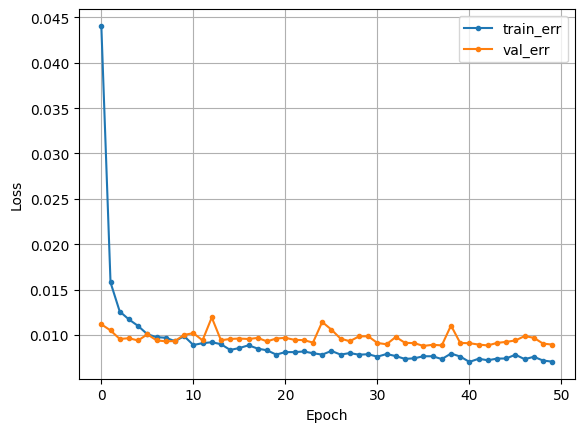

In [ ]:
dl_history_plot(history_lstm.history)

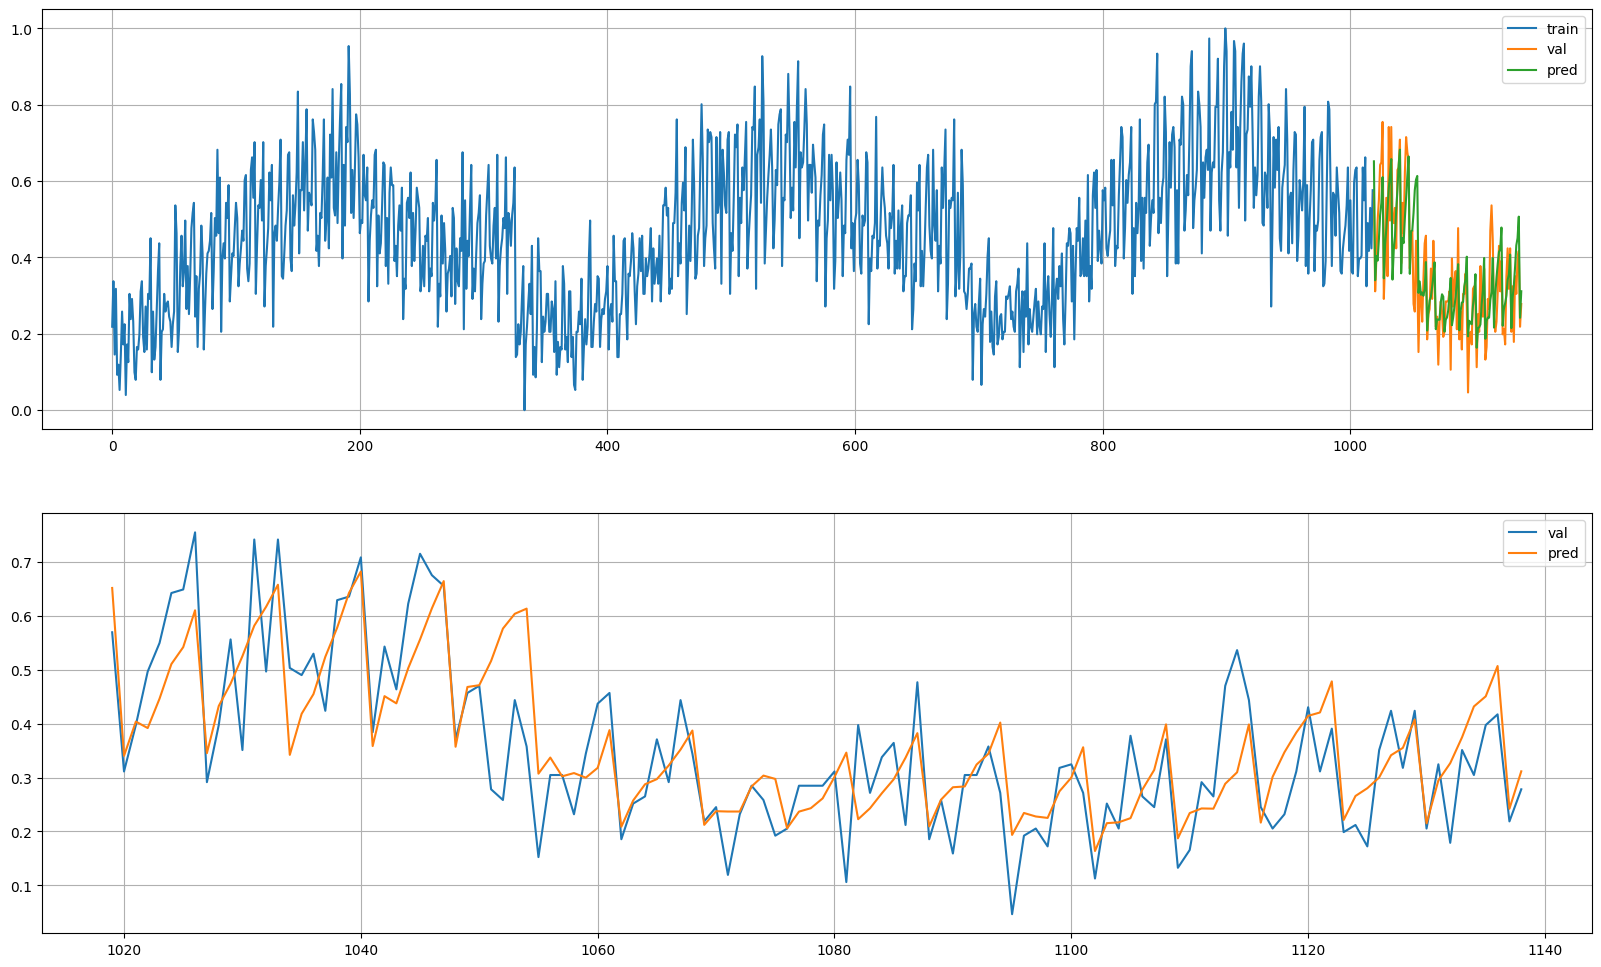

In [ ]:
plot_model_result(y_train, y_val, y_pred_lstm)

In [ ]:
sales_42_re = joblib.load(path + 'merged_42_re.pkl')

In [ ]:
sales_42_re = sales_42_re.iloc[17:]
sales_42_re

,Date,Qty,WTI_Price,CustomerCount,DayOfWeek,Month,Previous_Qty,1,2,3,...,10,17,18,20,44,45,46,47,48,49
19,2014-01-20,51.0,94.235,3661.0,Monday,January,71.0,852.000,1318.000,2442.000,...,1426.000,1282.000,736.000,0.0,1302.470,3509.000,3365.000,3429.000,3341.000,1984.00000
20,2014-01-21,71.0,94.510,3781.0,Tuesday,January,79.0,772.000,1056.000,2239.000,...,457.000,547.000,567.000,0.0,3181.000,3021.000,1933.000,2351.000,1712.000,1707.00000
21,2014-01-22,64.0,96.350,3954.0,Wednesday,January,51.0,195.000,258.000,660.000,...,44.000,175.000,156.000,0.0,2991.000,604.000,253.000,528.000,194.000,495.00000
22,2014-01-23,91.0,97.230,3568.0,Thursday,January,71.0,146.961,155.366,458.020,...,33.000,76.000,63.520,0.0,780.000,661.910,426.886,488.603,348.112,380.66998
23,2014-01-24,81.0,96.660,3971.0,Friday,January,64.0,2441.000,3750.000,8659.000,...,3511.519,4286.097,2396.273,0.0,600.931,11517.000,9639.000,10643.000,9282.000,6009.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,2017-02-24,91.0,53.990,4549.0,Friday,February,72.0,2009.000,2397.000,5705.000,...,903.000,2297.000,1916.000,0.0,438.000,5340.000,3061.000,4809.000,2721.000,4250.00000
1151,2017-02-25,105.0,53.990,4619.0,Saturday,February,98.0,366.610,336.408,855.484,...,114.000,205.000,966.000,0.0,292.055,678.195,350.529,681.256,392.769,522.56700
1152,2017-02-26,108.0,53.990,3877.0,Sunday,February,91.0,813.000,725.000,1824.000,...,698.000,874.000,551.000,0.0,5896.000,1774.000,1496.000,1649.000,1259.000,1293.00000
1153,2017-02-27,78.0,54.040,3961.0,Monday,February,105.0,666.000,667.000,1612.000,...,248.000,479.000,464.000,0.0,63.000,1721.000,928.000,1305.000,889.000,1358.00000


In [ ]:
def preproc3d(data, timesteps, y_scale = False) :
    target = 'Qty'
    x = data.drop([target,'Date','WTI_Price'], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['DayOfWeek'] = pd.Categorical(x['DayOfWeek'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['DayOfWeek','Month'])
    col_names = x.columns.tolist()


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [ ]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(sales_42_re,14, True)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((995, 14, 39), (120, 14, 39), (995,), (120,))

In [ ]:
clear_session()

lstm_model = Sequential([
    LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

history_lstm = lstm_model.fit(x_train, y_train, epochs=30, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0689 - val_loss: 0.0129
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0157 - val_loss: 0.0111
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0137 - val_loss: 0.0110
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0120 - val_loss: 0.0109
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0109 - val_loss: 0.0116
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0104 - val_loss: 0.0114
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0101 - val_loss: 0.0114
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - val_loss: 0.0107
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - v

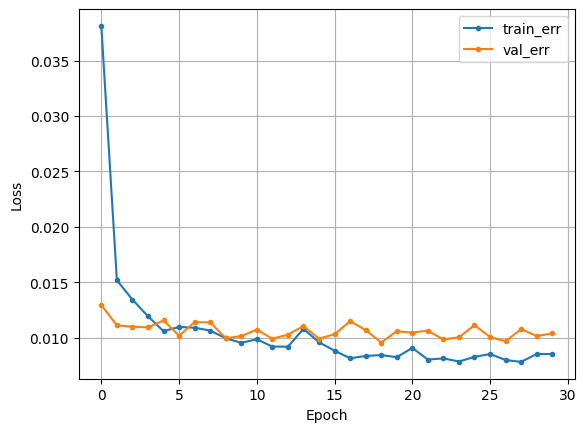

In [ ]:
dl_history_plot(history_lstm.history)

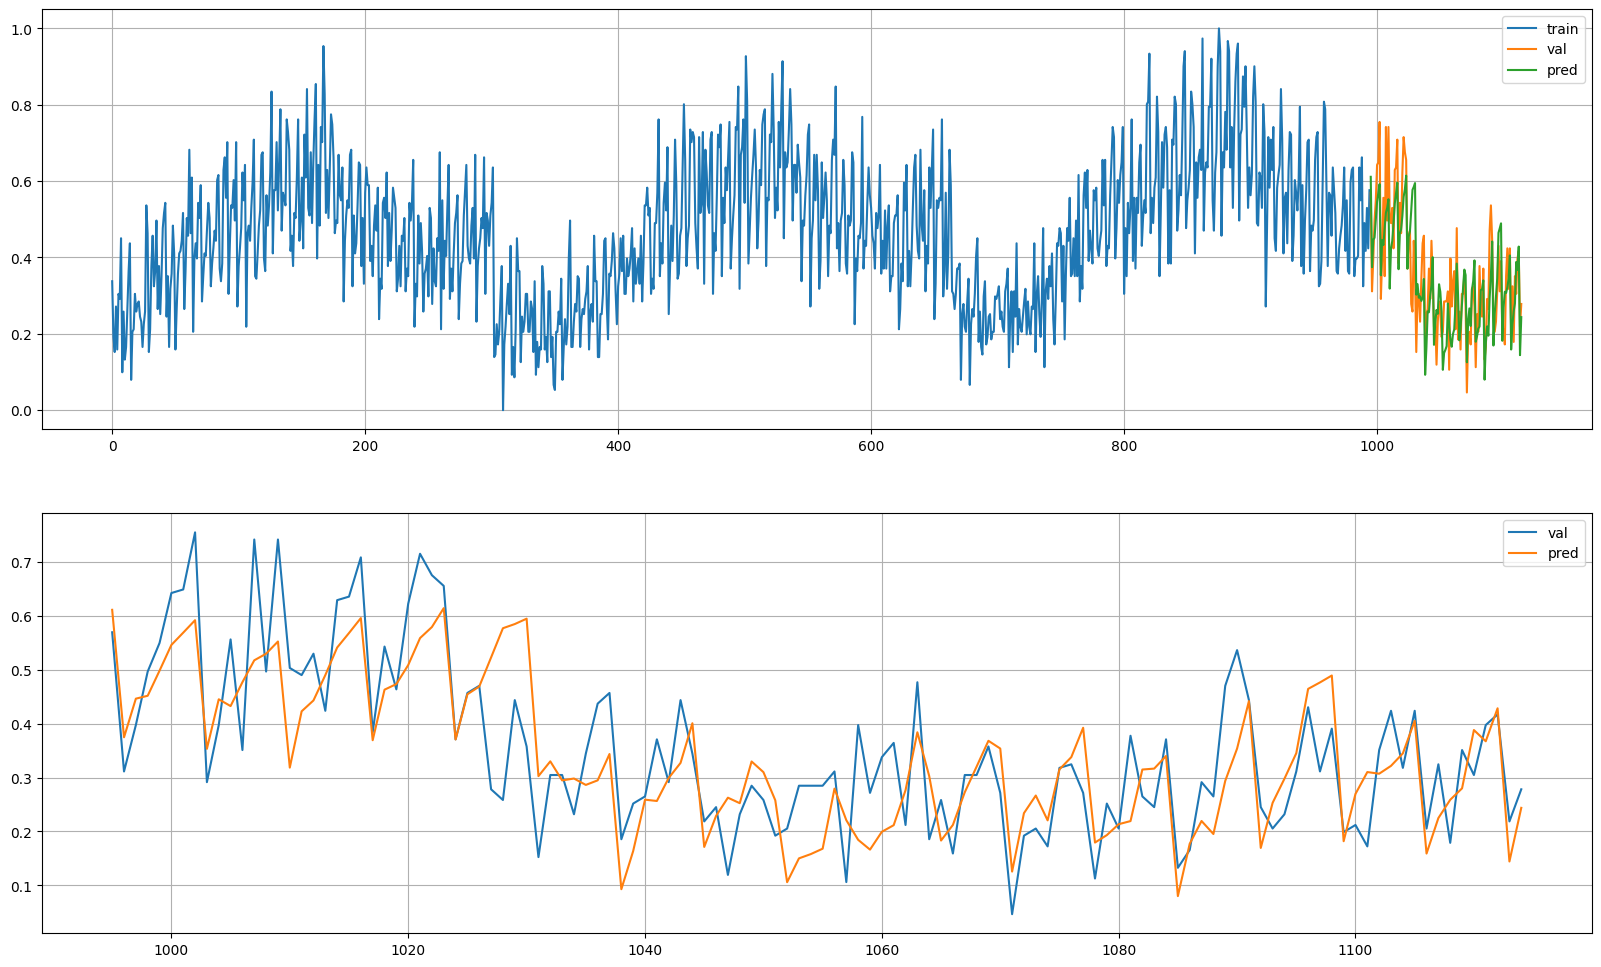

In [ ]:
plot_model_result(y_train, y_val, y_pred_lstm)

In [ ]:
y_pred_lstm = lstm_model.predict(x_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred_lstm))
mae = mean_absolute_error(y_val, y_pred_lstm)
r2 = r2_score(y_val, y_pred_lstm)

# Print evaluation metricsprint("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mean_absolute_percentage_error(y_val, y_pred_lstm))
print("R2 Score:", r2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
MAE: 0.07876925036212466
MAPE: 0.29302853670809836
R2 Score: 0.5624316838425589


## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [218]:
# 파이프라인에 작성

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
#파이프라인으로 생성

* **모델링**

In [ ]:
#파이프라인으로 생성

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dropout
clear_session()

cnn_model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mse')

history_cnn = cnn_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0806 - val_loss: 0.0265
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 - val_loss: 0.0149
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 - val_loss: 0.0096
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0115
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0144
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0099
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0096
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0101
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0099
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0100
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0102
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_l

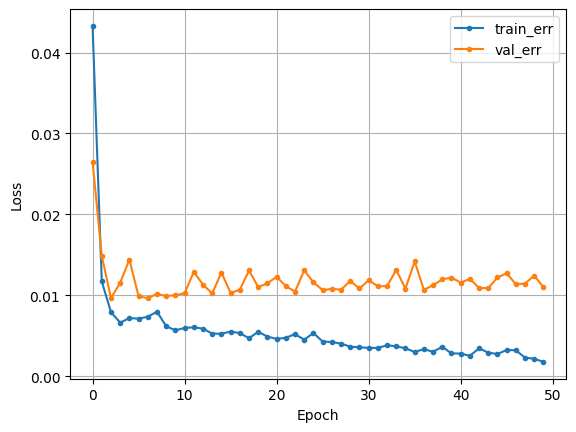

In [ ]:
dl_history_plot(history_cnn.history)

In [ ]:
y_pred_cnn = cnn_model.predict(x_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred_cnn))
mae = mean_absolute_error(y_val, y_pred_cnn)
r2 = r2_score(y_val, y_pred_cnn)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mean_absolute_percentage_error(y_val, y_pred_cnn))
print("R2 Score:", r2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
RMSE: 0.10474236439641971
MAE: 0.07486328744919554
MAPE: 0.2892245600674289
R2 Score: 0.5379363746494099


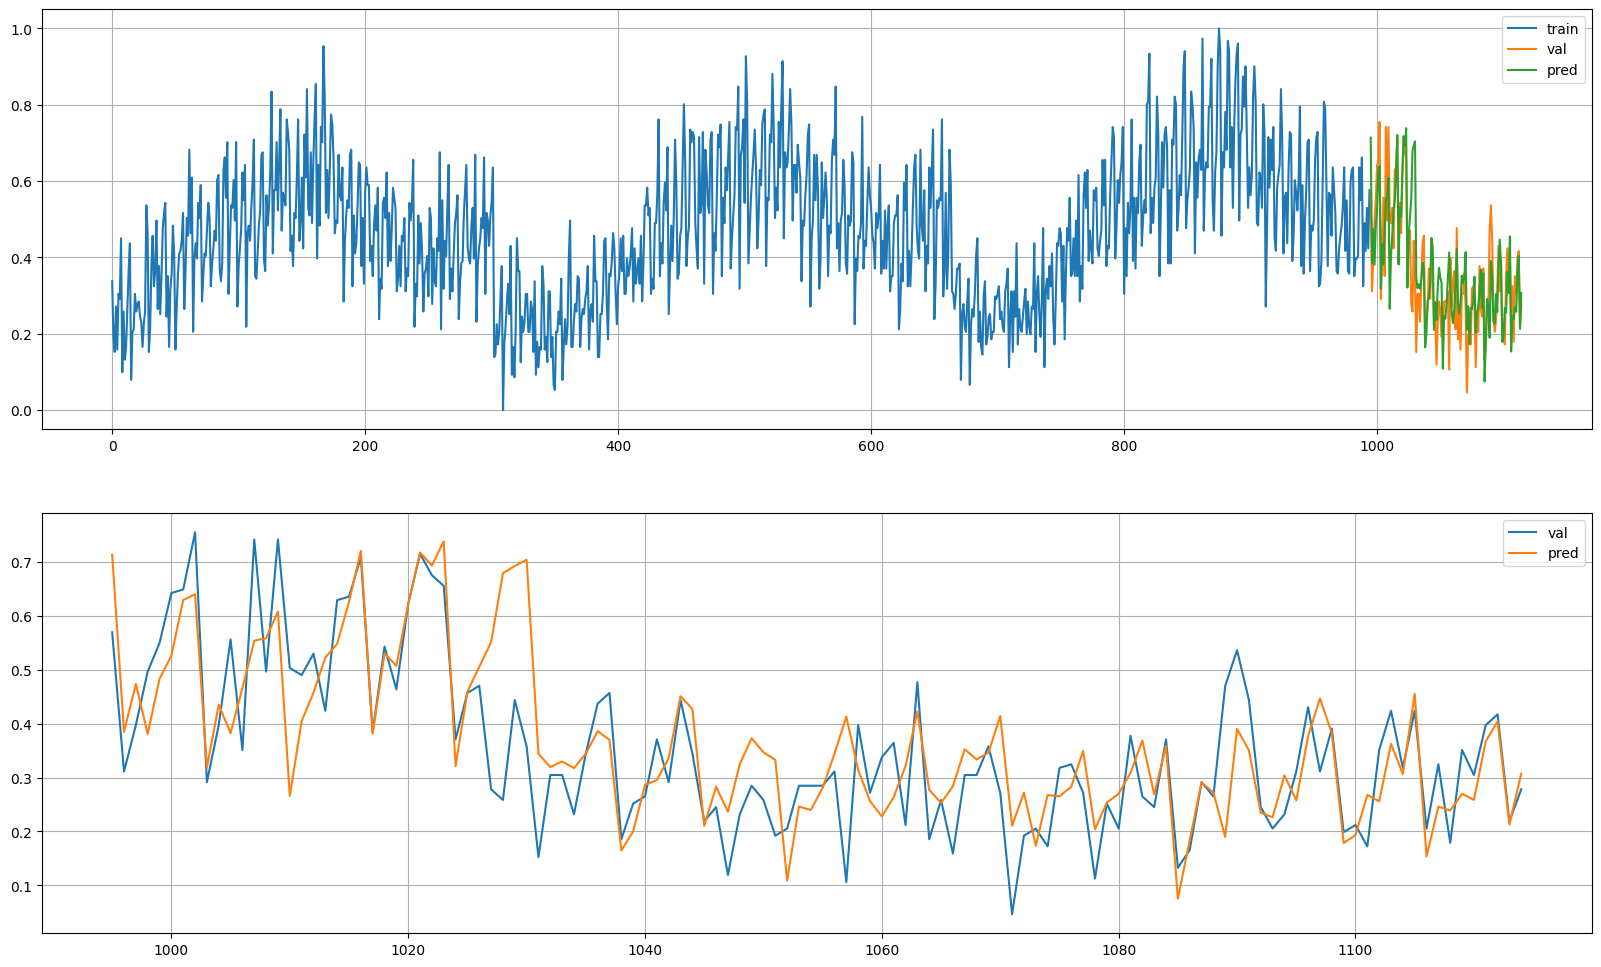

In [ ]:
plot_model_result(y_train, y_val, y_pred_cnn)

In [ ]:
#GRU 사용

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Define the GRU model
gru_model = Sequential([
    GRU(128, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    GRU(64, activation='relu', return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
gru_model.compile(optimizer='adam', loss='mse')

# Fit the model
history_gru = gru_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - loss: 0.1353 - val_loss: 0.0298
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0382 - val_loss: 0.0286
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0270 - val_loss: 0.0131
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - val_loss: 0.0089
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0122 - val_loss: 0.0087
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - val_loss: 0.0081
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0113 - val_loss: 0.0121
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0136 - val_loss: 0.0076
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - val_loss: 0.0077
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0083 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


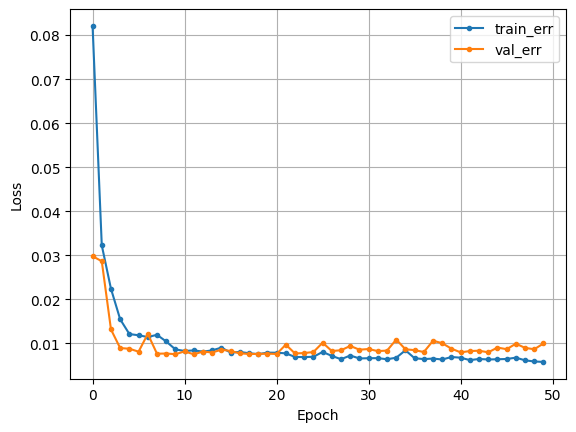

In [ ]:
y_pred_gru = gru_model.predict(x_val)

dl_history_plot(history_gru.history)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred_gru))
mae = mean_absolute_error(y_val, y_pred_gru)
r2 = r2_score(y_val, y_pred_gru)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mean_absolute_percentage_error(y_val, y_pred_gru))
print("R2 Score:", r2)

RMSE: 0.09967892672191454
MAE: 0.07565126579920976
MAPE: 0.23702606589937728
R2 Score: 0.5815305664336985


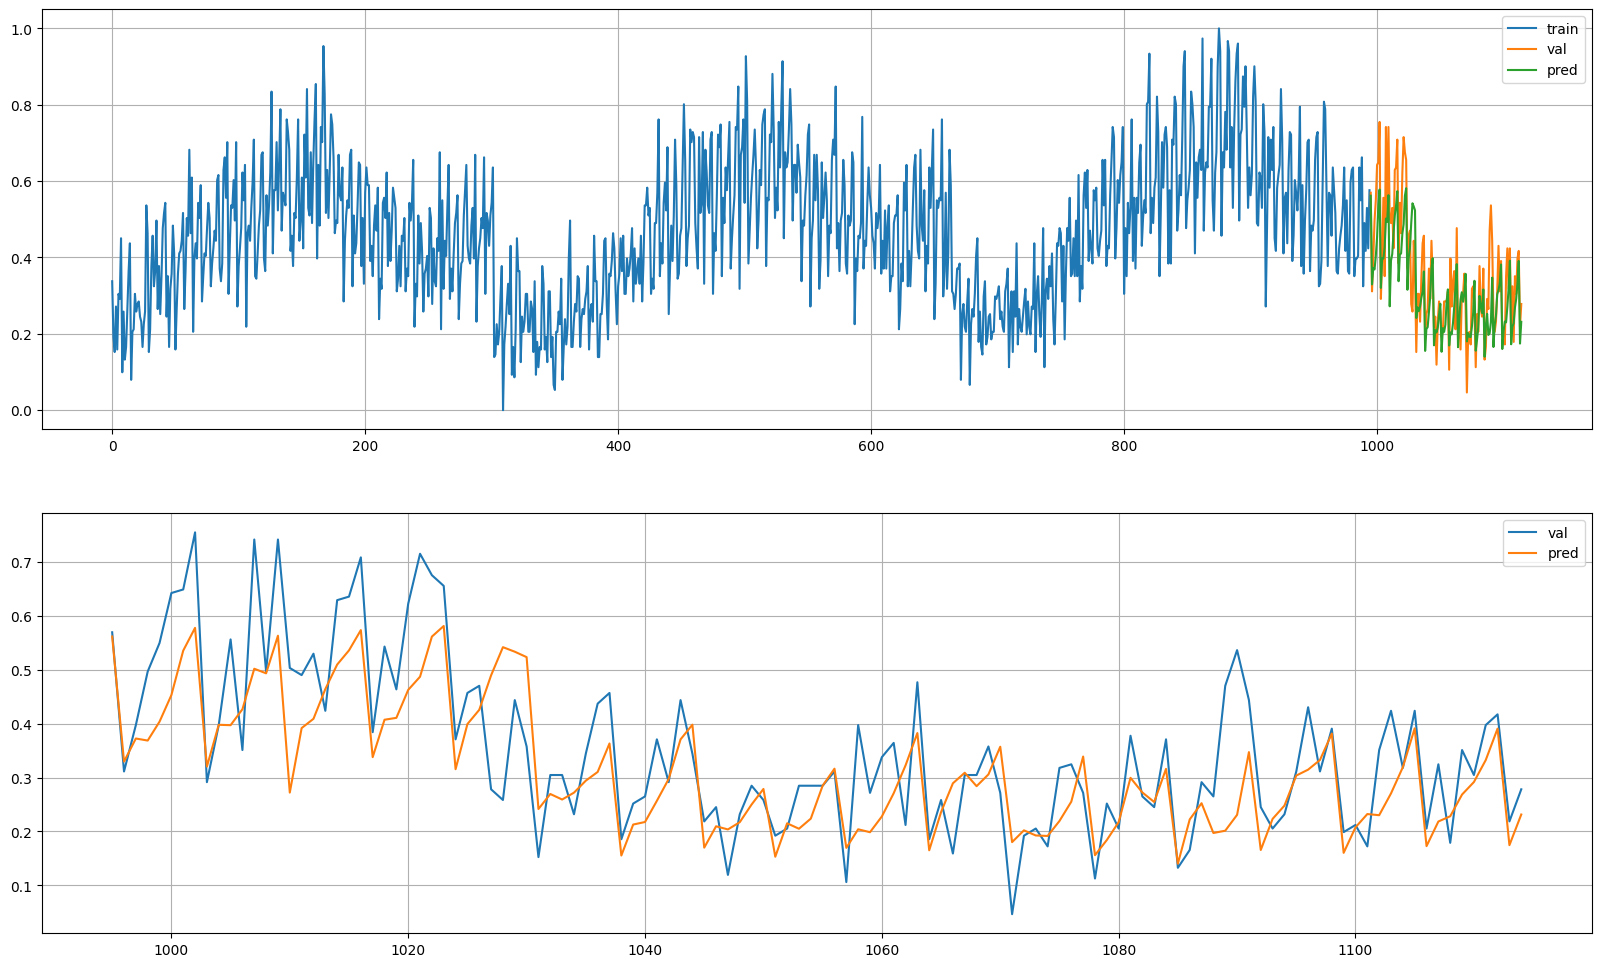

In [ ]:
plot_model_result(y_train, y_val, y_pred_gru)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

#### 3번

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.8544 - val_loss: 1.0038
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5758 - val_loss: 0.6532
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4694 - val_loss: 0.3377
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3333 - val_loss: 0.3052
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2410 - val_loss: 0.3643
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2730 - val_loss: 0.3185
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2186 - val_loss: 0.2657
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1852 - val_loss: 0.2414
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1799 - val_loss: 0.2591
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1986 - val_loss: 0.2949
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1789 - val_loss: 0.2487
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1957 - val_l

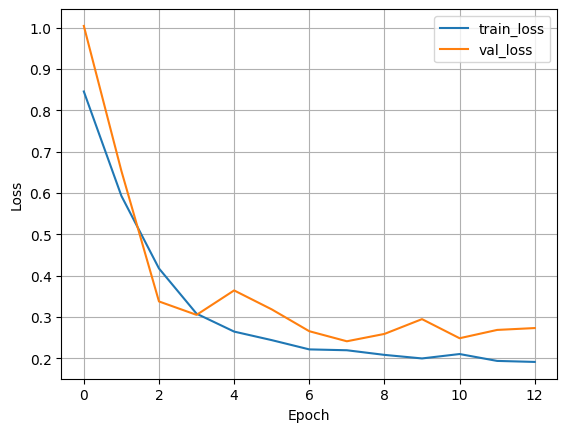

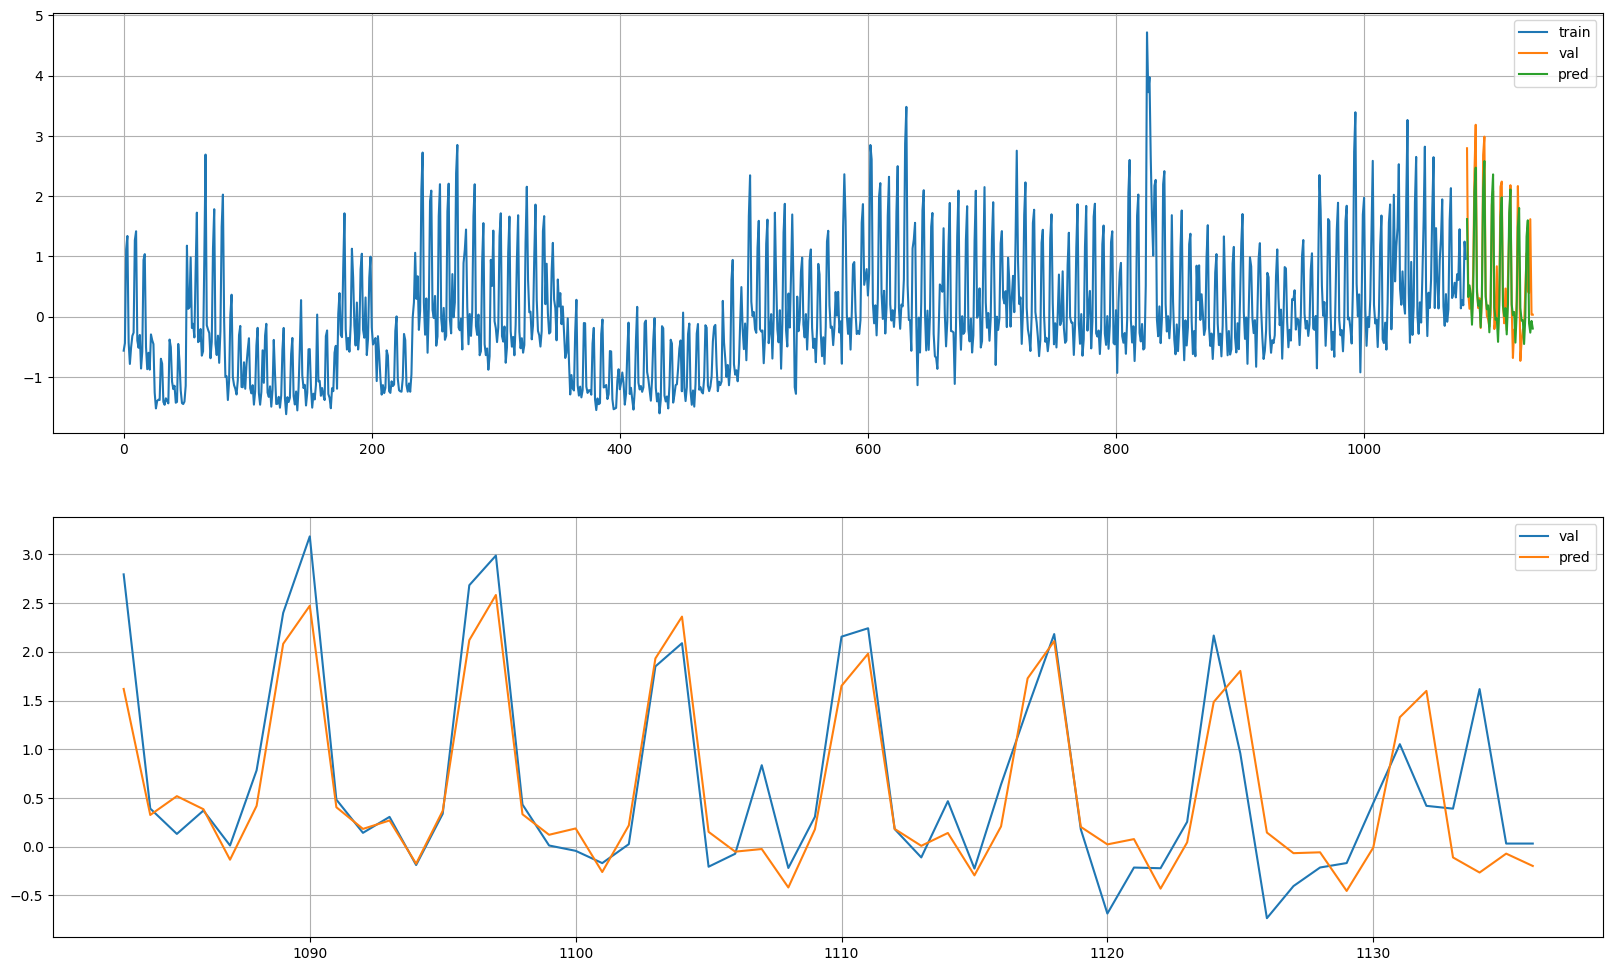

(<Sequential name=sequential_1, built=True>,
 StandardScaler(),
 StandardScaler())

In [217]:
def temporalize_3(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x[i : (i + timesteps)])
        output_y.append(y[i + timesteps - 1])
    return np.array(output_X), np.array(output_y)


# 예측 결과 시각화
def plot_model_result_3(y_train, y_val, pred) :

    y_train = pd.Series(y_train.reshape(-1,))
    y_val = pd.Series(y_val.reshape(-1,))
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()


from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping


loaded_cols = joblib.load(path + 'sales_3.pkl')

# 1. 계절성 추가
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

def data_split(loaded_cols):
  loaded_cols = loaded_cols.drop(columns=['Store_ID', 'Product_ID', 'SubCategory', 'Category', 'City', 'State', 'Product_Code', 'WTI_Price'])
  loaded_cols['CustomerCount'].fillna(loaded_cols['CustomerCount'].mean(), inplace=True)
  loaded_cols['y'].fillna(loaded_cols['y'].mean(), inplace=True)
  loaded_cols['season'] = loaded_cols['month'].apply(get_season)
  loaded_cols = loaded_cols.drop(columns=['LeadTime'])
  loaded_cols = loaded_cols.drop(columns=['Price', 'Store_Type'])
  # Dropping 'month' and 'year' columns as instructed
  loaded_cols = loaded_cols.drop(columns=['month', 'year'])
  # Filtering out rows where 'Qty' is 0, as instructed
  loaded_cols = loaded_cols[loaded_cols['y'] != 0]

  # Performing one-hot encoding on the 'weekday' column
  loaded_cols = pd.get_dummies(loaded_cols, columns=['weekday'], drop_first=True)


  # 2. 원-핫 인코딩
  loaded_cols = pd.get_dummies(loaded_cols, columns=['season'], drop_first=True)

  return loaded_cols


loaded_cols = data_split(loaded_cols)


loaded_cols.head()


def train_lstm_pipeline(model, data, target_col):
    # 파라미터 설정
    timesteps = 7
    test_size = 60
    batch_size = 32
    epochs = 50
    patience = 5

    # 1. Feature와 Target 분리
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # 2. 학습 및 검증 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # 3. 스케일링
    numeric_features = ['Qty', 'CustomerCount']
    scaler_X = StandardScaler()
    X_train[numeric_features] = scaler_X.fit_transform(X_train[numeric_features])
    X_val[numeric_features] = scaler_X.transform(X_val[numeric_features])

    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_val = scaler_y.transform(y_val.values.reshape(-1, 1))

    # 4. 시계열 데이터 형태로 변환
    X_train_seq, y_train_seq = temporalize_3(X_train.values, y_train, timesteps)
    X_val_seq, y_val_seq = temporalize_3(X_val.values, y_val, timesteps)

    # 데이터 형식을 float32로 변환
    X_train_seq = X_train_seq.astype(np.float32)
    y_train_seq = y_train_seq.astype(np.float32)
    X_val_seq = X_val_seq.astype(np.float32)
    y_val_seq = y_val_seq.astype(np.float32)

    # 5. 모델 빌드 - 동적으로 input_shape 설정
    model.build(input_shape=(None, X_train_seq.shape[1], X_train_seq.shape[2]))
    model.compile(optimizer='adam', loss='mse')

    # EarlyStopping 콜백 정의
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # 6. 모델 학습
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stopping]
    ).history

    # 7. 예측
    y_pred = model.predict(X_val_seq)

    # 8. 성능 평가
    rmse = np.sqrt(mean_squared_error(y_val_seq, y_pred))
    mae = mean_absolute_error(y_val_seq, y_pred)
    mape = np.mean(np.abs((y_val_seq - y_pred) / y_val_seq)) * 100
    r2 = r2_score(y_val_seq, y_pred)

    # 성능 지표 출력
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print("R2 Score:", r2)

    # 학습 곡선 시각화
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # 예측 결과 시각화
    plot_model_result_3(y_train_seq, y_val_seq, y_pred)

    return model, scaler_X, scaler_y  # 모델과 스케일러 반환



# 입력 데이터의 최신 shape에 맞게 모델 정의
model = Sequential([
    LSTM(50, activation='relu', input_shape=(7, 11)),  # 최신 데이터의 shape에 맞게 input_shape 설정
    Dense(1)
])

# 파이프라인 함수 호출
train_lstm_pipeline(model, loaded_cols, 'y')

#### 12번

In [211]:
def preproc3d_2(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop(columns = ['Date', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month'])
    col_names = list(x)

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 0.2, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [212]:
# train 데이터 로드
def train_lstm_pipeline(path):
  orders = pd.read_csv(path + 'train/orders_train.csv')
  sales = pd.read_csv(path + 'train/sales_train.csv')
  sales['Date'] = pd.to_datetime(sales['Date'])
  orders['Date'] = pd.to_datetime(orders['Date'])

  sales_44_12_train = sales[(sales['Product_ID'] == 12) & (sales['Store_ID'] == 44)]

  # 당일 고객수 merge
  sales_44_12_train = pd.merge(sales_44_12_train, orders[orders['Store_ID']==44], on='Date', how='left')

  # Store_ID 초기화
  sales_44_12_train = sales_44_12_train.drop(columns=['Store_ID_y'])
  sales_44_12_train = sales_44_12_train.rename(columns={'Store_ID_x': 'Store_ID'})

  # CustomerCount의 결측치를 평균으로 채우기
  sales_44_12_train['CustomerCount'] = sales_44_12_train['CustomerCount'].fillna(sales_44_12_train['CustomerCount'].mean())

  # WeekDay 생성
  sales_44_12_train['WeekDay'] = sales_44_12_train['Date'].dt.day_name()

  # 주 단위 컬럼 생성
  sales_44_12_train['Week'] = sales_44_12_train['Date'].dt.isocalendar().week
  # 월 단위 컬럼 생성
  sales_44_12_train['Month'] = sales_44_12_train['Date'].dt.month
  # 연도 컬럼 추가
  sales_44_12_train['Year'] = sales_44_12_train['Date'].dt.year

  quater = sales_44_12_train['Date'].dt.quarter
  # 시즌 컬럼 추가
  sales_44_12_train['Season'] = quater.map({1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'})

  # 리드타임(2일) 만큼 밀린 타깃 변수(y) 생성
  sales_44_12_train['target'] = sales_44_12_train['Qty'].shift(-2)

  # 마지막 날과 마지막 전날의 target 결측치 처리
  # 최근 5일의 Qty 평균으로 NaN 값 채우기
  sales_44_12_train['target'] = sales_44_12_train['target'].fillna(
      sales_44_12_train['Qty'].rolling(window=5, min_periods=1).mean()
  )

  # 최근 5일전 대비 판매량 변화 계산
  sales_44_12_train['Qty_Change_5_days'] = sales_44_12_train['Qty'].diff(periods=5)

  # 전체 5일간 판매량 변화 데이터의 평균으로 NaN 값을 채우기
  sales_44_12_train['Qty_Change_5_days'] = sales_44_12_train['Qty_Change_5_days'].fillna(sales_44_12_train['Qty_Change_5_days'].mean())

  # 필요 없는 컬럼 지우기
  sales_44_12_train = sales_44_12_train[sales_44_12_train['Qty'] != 0.0]
  sales_44_12_train = sales_44_12_train[sales_44_12_train['target'] != 0.0]
  sales_44_12_train = sales_44_12_train.drop(columns=['Season', 'Product_ID', 'Store_ID', 'Week'])

  preproc3d_2(sales_44_12_train, timesteps=14, y_scale = False)
  timesteps = 14

  x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d_2(sales_44_12_train, timesteps, True)

  clear_session()

  _, ts, nfeat = x_train.shape

  # LSTM 층 추가 (입력 차원: timesteps와 features에 맞춰 설정)
  model_Lstm = Sequential([LSTM(64, return_sequences=True, input_shape=(ts, nfeat)),
                          Dropout(0.2),
                          LSTM(32),
                          Dropout(0.2),
                          Dense(16, activation='relu'),
                          Dropout(0.2),
                          Dense(8, activation='relu'),
                          Dense(1) ])

  # 모델 구조 확인
  model_Lstm.summary()

  # 모델 컴파일 (옵티마이저, 손실 함수 설정)
  model_Lstm.compile(optimizer='adam', loss='mean_squared_error')

  # 모델 학습
  es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  history_Lstm = model_Lstm.fit(x_train, y_train,
                                epochs=50,
                                validation_split=0.2,
                                verbose=1,
                                callbacks=[es])

  y_pred = model_Lstm.predict(x_val)

  # 성능지표
  rmse = np.sqrt(mean_squared_error(y_val, y_pred))
  mae = mean_absolute_error(y_val, y_pred)
  mape = mean_absolute_percentage_error(y_val, y_pred)
  r2 = r2_score(y_val, y_pred)

  print("RMSE:", rmse)
  print("MAE:", mae)
  print("MAPE:", mape)
  print("R^2:", r2)
  plt.figure(figsize=(12, 6))
  plt.plot(y_val, label='y_test', marker='o')
  plt.plot(y_pred, label='LSTM', marker='x')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.title('Comparison of y_pred with y_val')
  plt.legend()
  plt.grid(True)
  plt.show()
    # 그래프
  #dl_history_plot(history_Lstm)
  # plot_model_result(y_train, y_val, y_pred)
  return sales_44_12_train, history_Lstm

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 14, 64)              │          22,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,617 (139.13 KB)

 Trainable params: 35,617 (139.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0677 - val_loss: 0.0368
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0210 - val_loss: 0.0144
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - val_loss: 0.0145
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - val_loss: 0.0141
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108 - val_loss: 0.0145
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - val_loss: 0.0139
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - val_loss: 0.0143
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - val_loss: 0.0148
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - val_loss: 0.0140
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
RMSE: 0.1092457472432607
MAE: 0.08155884742548047
MAPE: 0.40795240481013606
R^2: -0.02894937312276702


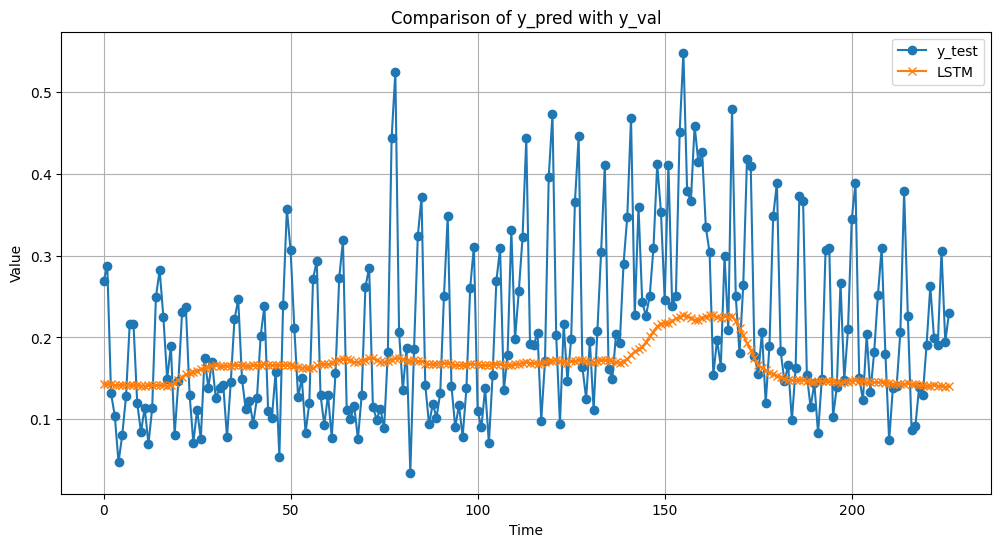

In [213]:
sales_44_12_train,_ = train_lstm_pipeline(path)

In [214]:
def test_lstm_pipeline(path, y_scale=True):
  orders = pd.read_csv(path + 'test/orders_test.csv')
  sales = pd.read_csv(path + 'test/sales_test.csv')
  sales['Date'] = pd.to_datetime(sales['Date'])
  orders['Date'] = pd.to_datetime(orders['Date'])

  sales_44_12_train = sales[(sales['Product_ID'] == 12) & (sales['Store_ID'] == 44)]

  # 당일 고객수 merge
  sales_44_12_train = pd.merge(sales_44_12_train, orders[orders['Store_ID']==44], on='Date', how='left')

  # Store_ID 초기화
  sales_44_12_train = sales_44_12_train.drop(columns=['Store_ID_y'])
  sales_44_12_train = sales_44_12_train.rename(columns={'Store_ID_x': 'Store_ID'})

  # CustomerCount의 결측치를 평균으로 채우기
  sales_44_12_train['CustomerCount'] = sales_44_12_train['CustomerCount'].fillna(sales_44_12_train['CustomerCount'].mean())

  # WeekDay 생성
  sales_44_12_train['WeekDay'] = sales_44_12_train['Date'].dt.day_name()

  # 주 단위 컬럼 생성
  sales_44_12_train['Week'] = sales_44_12_train['Date'].dt.isocalendar().week
  # 월 단위 컬럼 생성
  sales_44_12_train['Month'] = sales_44_12_train['Date'].dt.month
  # 연도 컬럼 추가
  sales_44_12_train['Year'] = sales_44_12_train['Date'].dt.year

  quater = sales_44_12_train['Date'].dt.quarter
  # 시즌 컬럼 추가
  sales_44_12_train['Season'] = quater.map({1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'})

  # 리드타임(2일) 만큼 밀린 타깃 변수(y) 생성
  sales_44_12_train['target'] = sales_44_12_train['Qty'].shift(-2)

  # 마지막 날과 마지막 전날의 target 결측치 처리
  # 최근 5일의 Qty 평균으로 NaN 값 채우기
  sales_44_12_train['target'] = sales_44_12_train['target'].fillna(
      sales_44_12_train['Qty'].rolling(window=5, min_periods=1).mean()
  )

  # 최근 5일전 대비 판매량 변화 계산
  sales_44_12_train['Qty_Change_5_days'] = sales_44_12_train['Qty'].diff(periods=5)

  # 전체 5일간 판매량 변화 데이터의 평균으로 NaN 값을 채우기
  sales_44_12_train['Qty_Change_5_days'] = sales_44_12_train['Qty_Change_5_days'].fillna(sales_44_12_train['Qty_Change_5_days'].mean())

  # 필요 없는 컬럼 지우기
  sales_44_12_train = sales_44_12_train[sales_44_12_train['Qty'] != 0.0]
  sales_44_12_train = sales_44_12_train[sales_44_12_train['target'] != 0.0]
  sales_44_12_train = sales_44_12_train.drop(columns=['Season', 'Product_ID', 'Store_ID', 'Week'])

  x = sales_44_12_train.drop(columns=['Date', 'target'], axis=1)
  y = sales_44_12_train.loc[:, 'target']
  x['WeekDay'] = pd.Categorical(x['WeekDay'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
  x['Month'] = pd.Categorical(x['Month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
  x = pd.get_dummies(x, columns=['WeekDay', 'Month'])
  col_names = x.columns.tolist()

    # Scaling
  scaler = MinMaxScaler()
  x = scaler.fit_transform(x)
  x = pd.DataFrame(x, columns=col_names)

    # Scale y if specified
  if y_scale:
      y_min, y_max = y.min(), y.max()
      y = (y - y_min) / (y_max - y_min)
  else:
      y_min, y_max = None, None

    # Temporalize data
  x_test, y_test = temporalize(x, y, 14)


  return x_test, y_test

In [215]:
x_test, y_test = test_lstm_pipeline(path)



In [216]:
y_pred_test = lstm_model.predict(x_test)

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/flatten_1/Reshape defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-216-0b395c0c120a>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 508, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 209, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 4440, in reshape

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1789, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/flatten_1/Reshape}}]] [Op:__inference_one_step_on_data_distributed_139721]

#### 42 prduct

In [139]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [158]:
def preprocessing4predict(path, y_scale=True, timesteps=7):
    oil_price = pd.read_csv(path + 'test/oil_price_test.csv')
    orders = pd.read_csv(path + 'test/orders_test.csv')
    sales = pd.read_csv(path + 'test/sales_test.csv')
    products = pd.read_csv(path + 'test/products.csv')
    stores = pd.read_csv(path + 'test/stores.csv')

    sales['Date'] = pd.to_datetime(sales['Date'] )
    oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
    orders['Date'] = pd.to_datetime(orders['Date'] )

    # Fill missing values in oil_price
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate(method='linear').fillna(method='bfill')

    # Filter sales for target store and product
    store_sales_44_42 = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 42)]
    merged_sales_44_42 = store_sales_44_42.merge(products, on='Product_ID', how='left')

    # Merge with oil_price
    merged_sales_44_42 = pd.merge(merged_sales_44_42, oil_price, on='Date', how='left')
    merged_sales_44_42['WTI_Price'] = merged_sales_44_42['WTI_Price'].fillna(method='ffill')

    # Merge with orders
    merged_42 = merged_sales_44_42.merge(
        orders[orders['Store_ID'] == 44][['Date', 'CustomerCount']], on='Date', how='left'
    )

    # Drop unnecessary columns
    del_cols = ['Store_ID', 'Product_ID', 'Product_Code', 'SubCategory', 'Category', 'LeadTime', 'Price']
    merged_42.drop(del_cols, axis=1, inplace=True)
    merged_42_original = merged_42.copy()

    # Add date-related columns
    merged_42['DayOfWeek'] = merged_42['Date'].dt.day_name()
    merged_42['Month'] = merged_42['Date'].dt.month_name()

    # Create column for previous day's Qty
    merged_42['Previous_Qty'] = merged_42['Qty'].shift(2)
    merged_42 = merged_42.dropna()  # Remove holidays and initial missing rows

    stores_minnesota = stores[stores['City'] == 'Saint Paul']

    for store_id in stores_minnesota['Store_ID'].unique():
      qty_by_store = sales[sales['Store_ID'] == store_id]['Qty']
      merged_42[str(store_id)] = qty_by_store.values[:len(merged_42)]

    # Prepare features and target
    target = 'Qty'
    x = merged_42.drop([target,'Date','WTI_Price'], axis=1)
    y = merged_42[target]

    # Encode categorical features
    x['DayOfWeek'] = pd.Categorical(x['DayOfWeek'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    x['Month'] = pd.Categorical(x['Month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    x = pd.get_dummies(x, columns=['DayOfWeek', 'Month'])
    col_names = x.columns.tolist()

    # Scaling
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # Scale y if specified
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = None, None

    # Temporalize data
    x_test, y_test = temporalize(x, y, timesteps)

    return merged_42, x_test, y_test

In [163]:
sales_test, x_test, y_test = preprocessing4predict(path,timesteps=14)

In [164]:
x_test.shape, y_test.shape

((16, 14, 39), (16,))

* 예측해보기

In [168]:
#예측하기
y_pred_test1 = lstm_model.predict(x_test)
y_pred_test2 = cnn_model.predict(x_test)
y_pred_test3 = gru_model.predict(x_test)

print("LSTM_rmse:", np.sqrt(mean_squared_error(y_test, y_pred_test1)))
print("LSTM_mae:", mean_absolute_error(y_test, y_pred_test1))
print("LSTM_mape:", mean_absolute_percentage_error(y_test, y_pred_test1))
print("LSTM_R2:", r2_score(y_test, y_pred_test1))
print("-----------------------------------------------------")
print("CNN_rmse:", np.sqrt(mean_squared_error(y_test, y_pred_test2)))
print("CNN_mae:", mean_absolute_error(y_test, y_pred_test2))
print("CNN_mape:", mean_absolute_percentage_error(y_test, y_pred_test2))
print("CNN_R2:", r2_score(y_test, y_pred_test2))
print("-----------------------------------------------------")
print("GRU_rmse:", np.sqrt(mean_squared_error(y_test, y_pred_test3)))
print("GRU_mae:", mean_absolute_error(y_test, y_pred_test3))
print("GRU_mape:", mean_absolute_error(y_test, y_pred_test3))
print("GRU_R2:", r2_score(y_test, y_pred_test3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM_rmse: 0.1725598930642922
LSTM_mae: 0.13321346561941835
LSTM_mape: 1.7854014964938936
LSTM_R2: 0.4658323961133801
-----------------------------------------------------
CNN_rmse: 0.16343345487075395
CNN_mae: 0.12020270065182732
CNN_mape: 1.297924481511052
CNN_R2: 0.5208408977868368
-----------------------------------------------------
GRU_rmse: 0.19018831974642525
GRU_mae: 0.14542285443121006
GRU_mape: 0.14542285443121006
GRU_R2: 0.35111833506952816


In [198]:
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 14, 128)             │          64,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,309 (1.20 MB)

 Trainable params: 104,769 (409.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 209,540 (818.52 KB)

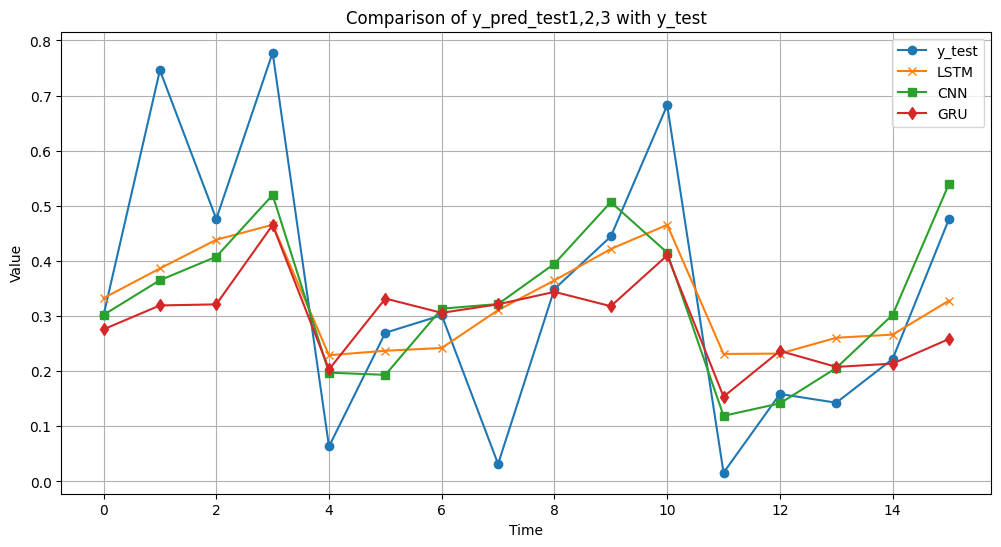

In [176]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='y_test', marker='o')
plt.plot(y_pred_test1, label='LSTM', marker='x')
plt.plot(y_pred_test2, label='CNN', marker='s')
plt.plot(y_pred_test3, label='GRU', marker='d')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of y_pred_test1,2,3 with y_test')
plt.legend()
plt.grid(True)
plt.show()

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [172]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [174]:
# prompt: 스케일링된 y_test,y_pred_test1,2,3를 되돌려줘.

# 원래 스케일로 되돌리기
y_test_original = y_test * (y_max - y_min) + y_min
y_pred_test1_original = y_pred_test1 * (y_max - y_min) + y_min
y_pred_test2_original = y_pred_test2 * (y_max - y_min) + y_min
y_pred_test3_original = y_pred_test3 * (y_max - y_min) + y_min


In [175]:
inv_simulator(y_test_original, y_pred_test1_original, 100, 5)

일평균 재고량     : 156.15
일평균 재고 금액  : 780.75
일평균 재고회전율 : 0.693
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,90.539683,95.0,190.539683,100,111,90.539683,0.0
1,157.650794,103.0,257.650794,100,115,157.650794,0.0
2,116.904762,111.0,211.000000,94,86,111.000000,0.0
3,162.444444,115.0,209.000000,47,134,115.000000,0.0
4,54.587302,80.0,133.000000,78,104,86.000000,0.0
5,85.746032,81.0,212.000000,126,66,134.000000,0.0
6,90.539683,82.0,230.000000,139,61,104.000000,0.0
7,49.793651,92.0,205.000000,155,54,66.000000,0.0
8,97.730159,100.0,216.000000,118,97,61.000000,0.0
9,112.111111,109.0,172.000000,60,120,54.000000,0.0
